In [22]:
from utils import spark

# load data movie

In [23]:
df_movies=spark.read.csv('data/movies.csv',header=True)
df_movies.show(n=2)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
|      2|  Jumanji (1995)|Adventure|Childre...|
+-------+----------------+--------------------+
only showing top 2 rows



# load Data rating

In [24]:
df_rating=spark.read.csv('data/ratings.csv',header=True).select('userId','movieId','rating')
df_rating.show(n=5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
|     1|    665|   5.0|
|     1|    899|   3.5|
+------+-------+------+
only showing top 5 rows



In [25]:
df_rating.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



In [26]:
from pyspark.sql.types import IntegerType, DoubleType
df_rating=df_rating.withColumn("movieId", df_rating["movieId"].cast(IntegerType()))\
                   .withColumn("userId",df_rating['userId'].cast(IntegerType()))\
                   .withColumn("rating",df_rating['rating'].cast(DoubleType()))
df_rating.show(5,truncate=False)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|1     |296    |5.0   |
|1     |306    |3.5   |
|1     |307    |5.0   |
|1     |665    |5.0   |
|1     |899    |3.5   |
+------+-------+------+
only showing top 5 rows



Calculate sparsity

In [34]:
# count total of number in dataset
numerator=df_rating.select('rating').count()
num_user=df_rating.select('userId').distinct().count()
num_movie=df_movies.select('movieId').distinct().count()
denominator = num_user * num_movie
sparsity=(1.0-(numerator * 1.0)/denominator) *100
print(f"The ratings dataframe is {sparsity:.2f} % empty")

The ratings dataframe is 99.75 % empty


# data tag

In [27]:
df_tag=spark.read.csv("data/tags.csv",header=True)
df_tag.show(n=5)

+------+-------+----------------+----------+
|userId|movieId|             tag| timestamp|
+------+-------+----------------+----------+
|     3|    260|         classic|1439472355|
|     3|    260|          sci-fi|1439472256|
|     4|   1732|     dark comedy|1573943598|
|     4|   1732|  great dialogue|1573943604|
|     4|   7569|so bad it's good|1573943455|
+------+-------+----------------+----------+
only showing top 5 rows



In [48]:
count_tag=df_tag.groupBy('tag').count().orderBy('count',ascending=False)
count_tag.show()

+------------------+-----+
|               tag|count|
+------------------+-----+
|            sci-fi| 8330|
|       atmospheric| 6516|
|            action| 5907|
|            comedy| 5702|
|           surreal| 5326|
|   based on a book| 5079|
|      twist ending| 4820|
|             funny| 4738|
|visually appealing| 4526|
|          dystopia| 4257|
|       dark comedy| 4026|
|              BD-R| 3966|
| thought-provoking| 3844|
|           romance| 3791|
|          stylized| 3728|
|            quirky| 3677|
|        psychology| 3625|
|    woman director| 3589|
|           fantasy| 3523|
|           classic| 3456|
+------------------+-----+
only showing top 20 rows



<Axes: >

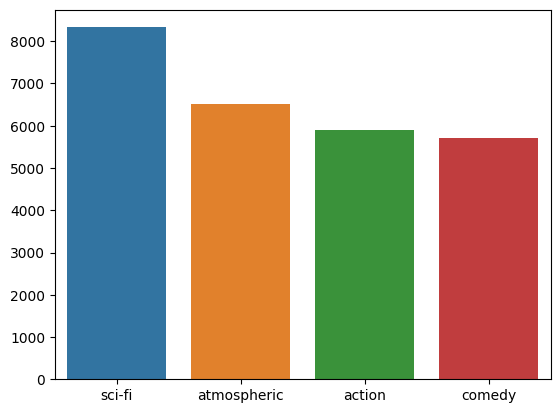

In [53]:
import seaborn as sns
# Extract the 'tag' and 'count' columns as separate lists
top_tags=count_tag.limit(4)
tags = top_tags.select('tag').rdd.flatMap(lambda x: x).collect()
counts = top_tags.select('count').rdd.flatMap(lambda x: x).collect()
sns.barplot(x=tags,y=counts)

# genome tag dan score

In [49]:
genome_score=spark.read.csv('data/genome-scores.csv',header=True)
genome_tag=spark.read.csv('data/genome-tags.csv',header=True)
# genome_tag.show(5,truncate=False)
genome_score.show(5,truncate=False)
genome=genome_tag.join(genome_score,on='tagId')
genome.show(5,truncate=False)

+-------+-----+--------------------+
|movieId|tagId|relevance           |
+-------+-----+--------------------+
|1      |1    |0.028749999999999998|
|1      |2    |0.023749999999999993|
|1      |3    |0.0625              |
|1      |4    |0.07574999999999998 |
|1      |5    |0.14075             |
+-------+-----+--------------------+
only showing top 5 rows

+-----+------------+-------+--------------------+
|tagId|tag         |movieId|relevance           |
+-----+------------+-------+--------------------+
|1    |007         |1      |0.028749999999999998|
|2    |007 (series)|1      |0.023749999999999993|
|3    |18th century|1      |0.0625              |
|4    |1920s       |1      |0.07574999999999998 |
|5    |1930s       |1      |0.14075             |
+-----+------------+-------+--------------------+
only showing top 5 rows



# Join data

In [29]:
gabung1=df_rating.join(df_movies,on='movieId').select('userId','movieId',
                                                      'genres','title','rating')
gabung1.show(5,truncate=False)

+------+-------+---------------------------+------------------------------------------------+------+
|userId|movieId|genres                     |title                                           |rating|
+------+-------+---------------------------+------------------------------------------------+------+
|1     |296    |Comedy|Crime|Drama|Thriller|Pulp Fiction (1994)                             |5.0   |
|1     |306    |Drama                      |Three Colors: Red (Trois couleurs: Rouge) (1994)|3.5   |
|1     |307    |Drama                      |Three Colors: Blue (Trois couleurs: Bleu) (1993)|5.0   |
|1     |665    |Comedy|Drama|War           |Underground (1995)                              |5.0   |
|1     |899    |Comedy|Musical|Romance     |Singin' in the Rain (1952)                      |3.5   |
+------+-------+---------------------------+------------------------------------------------+------+
only showing top 5 rows

